<h1 style="text-align: center;">Cyclistic Bike-Share Analysis</h1>
<h2 style="text-align: center;">Forecasting Demand and Understanding Rider Behavior for Strategic Growth</h2>
<p style="text-align: center;"><i>By Neetika Upadhyay</i><br><i>March 2025</i></p>

### Introduction
This project is focused on analyzing historical trip data from **Cyclistic**, a fictional bike-share company based in **Chicago**. The project will be fully implemented using **Python and Jupyter Notebook**.
### Objective
Cyclistic offers a fleet of **5,824** tracked bicycles connected through **692 docking stations** across Chicago. Cyclistic serves two types of users:

- **Members**: Customers with annual subscriptions.
- **Casuals**: Customers using single-ride or full-day passes.

This project explores the differences in riding behavior between casual and member riders to support a data-driven marketing strategy focused on converting casual users into annual members — a key objective for Cyclistic’s long-term growth.

### Analysis Questions:
- How do annual members and casual riders use Cyclistic bikes differently?
- How does bike usage vary over time between casual and member riders, and how can these trends be used to forecast future demand and guide targeted marketing strategies?

### Methodology:

- Data Collection
- Data Exploration and Prepration
- Analysis & Data Visualization (including Geospatial Analysis and Time Series Forecasting Analysis)
- Recommendation

## Data Collection

The dataset consists of 12 monthly CSV files for the year 2024, available in the divvy-tripdata directory. The first step involves importing and saving these datasets for further analysis. Before that, essential Python libraries required for the project are imported. The remaining steps will be introduced progressively as the project unfolds.

**1) Importing Required Libraries**

The following Python libraries are used:
- pandas for data manipulation
- numpy for numerical operations
- matplotlib and seaborn for visualizing
- datetime module provides functions to work with date and time
- zipfile to extract, and read files inside a ZIP archive
- io to read ZIP files directly from a web response
- requests to send HTTP requests in Python and fetch data from the web
- gc to free up memory by cleaning up objects that are no longer in use (but haven’t been deleted automatically yet)
- warnings to suppress all warning messages

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set()
import zipfile
import io
import requests
import gc
import warnings
warnings.filterwarnings("ignore")

**2) Importing and Saving the Dataset**

12 individual CSV files, each representing a month of 2024, stored in a remote ZIP file source are consolidated. The following steps are performed:

- Download ZIP files for each month
- Extract and read the CSV files
- Standardize date formats
- Merge all monthly data into a single DataFrame

This approach ensures that all 2024 trip data is integrated into a single DataFrame (combined_df) for analysis.

In [3]:
# List to store monthly DataFrames
df_list = []

# Loop through months
for month in [str(i).zfill(2) for i in range(1, 13)]:
    zip_url = f"https://divvy-tripdata.s3.amazonaws.com/2024{month}-divvy-tripdata.zip"
    response = requests.get(zip_url)

    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_file_name = z.namelist()[0]

            if csv_file_name.lower().endswith(".csv"):
                print(f"Processing data for 2024-{month}...")

                with z.open(csv_file_name) as csv_file:
                    # Use specific dtypes to reduce memory usage
                    dtype_map = {
                        "ride_id": "category",
                        "rideable_type": "category",
                        "start_station_name": "category",
                        "start_station_id": "category",
                        "end_station_name": "category",
                        "end_station_id": "category",
                        "member_casual": "category"
                    }

                    # Read CSV first
                    temp_df = pd.read_csv(csv_file, dtype=dtype_map)

                    # Normalize datetime columns
                    temp_df['started_at'] = pd.to_datetime(temp_df['started_at'], errors='coerce', infer_datetime_format=True)
                    temp_df['ended_at'] = pd.to_datetime(temp_df['ended_at'], errors='coerce', infer_datetime_format=True)

                    df_list.append(temp_df)
    else:
        print(f"Failed to download data for 2024-{month} (Status code: {response.status_code})")

# Combine all monthly DataFrames
combined_df = pd.concat(df_list, ignore_index=True)
print("All months combined. Final shape:", combined_df.shape)

Processing data for 2024-01...
Processing data for 2024-02...
Processing data for 2024-03...
Processing data for 2024-04...
Processing data for 2024-05...
Processing data for 2024-06...
Processing data for 2024-07...
Processing data for 2024-08...
Processing data for 2024-09...
Processing data for 2024-10...
Processing data for 2024-11...
Processing data for 2024-12...
All months combined. Final shape: (5860568, 13)


In [6]:
# Save with consistent datetime format
combined_df.to_csv('combined_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

In [7]:
del combined_df
gc.collect()

0

In [10]:
# Read saved file with parsed dates
combined_df = pd.read_csv('combined_data.csv', parse_dates=['started_at', 'ended_at'])

## Data Exploration and Prepration

**1) Previewing the Dataset**

head() function is used to get an initial look at the dataset. This helps us:
- Understand the data structure and verify that the merge was successful.
- Check the column names and their order.
- Identify any potential data quality issues such as missing or inconsistent values.

In [13]:
# Display first few rows
combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.903267,-87.634737,41.889177,-87.638506,member
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902937,-87.634440,41.889177,-87.638506,member
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902951,-87.634470,41.889177,-87.638506,member
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,TA1305000030,Larrabee St & Webster Ave,13193,41.884295,-87.633963,41.921822,-87.644140,member
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,13253,Kingsbury St & Kinzie St,KA1503000043,41.948797,-87.675278,41.889177,-87.638506,member


**2) Checking the Structure and Dimensions of the Merged Dataset**

Before proceeding with data analysis, there is need to understand the dataset. 

- The info() function helps to check the data types of each column. This step ensures that the data is formatted correctly and helps to decide on necessary preprocessing steps.
- To get an overview of the dataset size, shape attribute is used. It returns a tuple (rows, columns), that determines how much data is there to work.
- This will compare the dataset before and after cleaning to ensure no unexpected data loss.

In [16]:
# Check structure of the merged dataset
combined_df.info()

# check number of rows and columns in the merged dataset
combined_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860568 entries, 0 to 5860567
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 581.3+ MB


(5860568, 13)

**3) Cleaning and Formatting Date Columns**

Converting started_at and ended_at Columns to Datetime Format
The started_at and ended_at columns were stored as object (string) data types after reading from the CSV file. These columns are converted to datetime format using pd.to_datetime() to enable accurate time-based analysis.

**4) Extracting Unique Months**

Extracted the month from the started_at and ended_at datetime columns in the combined_df DataFrame by using .dt.month attribute. .unique() function is used that returns an array of the unique month values present in each column.

This step helps ensure that the combined_df contains valid and expected month values in both the started_at and ended_at columns, facilitating further analysis based on months.

In [20]:
# Extract and print unique months from the 'started_at' column
print(combined_df['started_at'].dt.month.unique())

# Extract and print unique months from the 'ended_at' column
print(combined_df['ended_at'].dt.month.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


**5) Identifying Duplicate Rows**

This step indentifies any duplicate rows in the combined_df DataFrame to ensure the integrity of the data.

- The function duplicated() is used to check for duplicate rows in the DataFrame. It returns a boolean Series where True indicates a duplicate row.
- The sum() function is applied to count the number of True values, which represent the number of duplicate rows.
- Finally, the total count of duplicate rows is printed and there is no duplicate row found.

In [23]:
# Count duplicate rows
duplicates = combined_df.duplicated().sum()
print(f"Duplicate Rows Found: {duplicates}")

Duplicate Rows Found: 211


**6) Removing Duplicate Rows**

.drop_duplicates() method in pandas is used to remove duplicate records as found above

In [25]:
# Remove duplicate rows from the DataFrame
combined_df = combined_df.drop_duplicates()

# Check the new shape after removing duplicates
print("Shape after removing duplicates:", combined_df.shape)

Shape after removing duplicates: (5860357, 13)


**7) Checking for Missing Values**

This is to ensure that the dataset has complete data:
- Count the number of missing values in each column.

In [29]:
# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1073928
start_station_id      1073928
end_station_name      1104573
end_station_id        1104573
start_lat                   0
start_lng                   0
end_lat                  7192
end_lng                  7192
member_casual               0
dtype: int64


**8) Dropping Rows with Null End Latitude and Longitude**

In this step, we remove rows from the combined_df DataFrame where the end_lat (end latitude) or end_lng (end longitude) values are missing. The absence of latitude and longitude makes these rows invalid for analysis. Also these rows constitute less than 0.5% (7,232) of the total row count (5,860,568). it won't impact our analysis

***Dropping Rows with Null End Latitude (end_lat)***:
   - The dropna() function is used to drop rows where the end_lat column has null values.
   - The subset parameter is specified to only check for null values in the end_lat column.
   - After dropping the rows, the index is reset using reset_index(drop=True) to maintain a continuous index.

***Dropping Rows with Null End Longitude (end_lng)***:
   - Similarly, another call to dropna() is used to remove rows where the end_lng column contains null values.
   - Again, the index is reset after removing these rows.

In [32]:
# dropping rows where end latitude and longitude are nulll
combined_df = combined_df.dropna(subset=['end_lat']).reset_index(drop = True)
combined_df = combined_df.dropna(subset=['end_lng']).reset_index(drop = True)

**9) Handling Null Values for Station Names**

The columns start_station_name, start_station_id, end_station_name, and end_station_id were found to have missing values. Since start_station_name and start_station_id are related, as are end_station_name, and end_station_id, the filling process was applied to the start_station_name and end_station_name columns. 

To fill these columns, backfilling technique is used. Here’s the process followed:

1. **Filling Missing Values for start_station_name**:
   - Rows were sorted based on the start_lat and start_lng columns in ascending order.
   - After sorting, the backfilling method fillna() was applied to fill in the missing values in the start_station_name column.

2. **Filling Missing Values for end_station_name**:
   - Rows were then sorted by end_lat and end_lng in ascending order.
   - Finally, the backfilling method fillna() was applied to fill in the missing values in the end_station_name column

There were some null values found in the start_station_name and end_station_name after performing backward filling so forwardfiling method was applied as well.

Both these method helped in filing the missing station names efficiently, ensuring that related values are properly filled.

In [35]:
# sorting columns in ascending order based on the start_lat and start_lng columns
combined_df = combined_df.sort_values(by = ['start_lat','start_lng'], ascending = False).reset_index(drop = True)

# Backward fill missing values in start_station_name
combined_df['start_station_name'] = combined_df['start_station_name'].fillna(method='bfill')

# Forward fill missing values in start_station_name
combined_df['start_station_name'] = combined_df['start_station_name'].fillna(method='ffill')

# sorting columns in ascending order based on the end_lat and end_lng columns
combined_df = combined_df.sort_values(by = ['end_lat','end_lng'], ascending = False).reset_index(drop = True)

# Backward fill missing values in end_station_name
combined_df['end_station_name'] = combined_df['end_station_name'].fillna(method='bfill')

# Forward fill missing values in end_station_name
combined_df['end_station_name'] = combined_df['end_station_name'].fillna(method='ffill')

# checking null values again
combined_df.isna().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name          0
start_station_id      1073928
end_station_name            0
end_station_id        1097381
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
dtype: int64

**10) Adding Calculated Columns**

The following code performs a series of transformations to the dataset, creating new columns that provide additional insights about the trip data:

**Trip Duration**

- The code calculates the duration of each trip by subtracting the started_at timestamp from the ended_at timestamp.
- The result of this operation is stored in a new column called trip_duration, which represents the difference between the start and end times of each trip.
- The trip_duration column, which was initially calculated as a timedelta type, is then formatted into a more readable format: '0 days HH:MM:SS'.
- The .apply() function is used to convert each timedelta value into a string with the desired format.

**Weekday of Each Trip**

- A new column trip_day is added to the DataFrame to capture the weekday of each trip. This is done by using the .strftime('%A') function on the started_at column, which extracts the full name of the day of the week (e.g., Monday, Tuesday).

**Month of Each Trip**
- Another new column, trip_month, is created to capture the month in which the trip occurred. The .strftime('%B') function extracts the full month name (e.g., January, February).

In [38]:
# Adding a calculated column for the duration of each trip
combined_df["trip_duration"] = combined_df["ended_at"] - combined_df["started_at"]

# Format trip duration as '0 days HH:MM:SS'
combined_df["trip_duration"] = combined_df["trip_duration"].apply(
    lambda x: f"{x.days} days {str(x.seconds // 3600).zfill(2)}:{str((x.seconds % 3600) // 60).zfill(2)}:{str(x.seconds % 60).zfill(2)}"
)

# finding weekday of the trip and adding column to dataframe
combined_df['trip_day'] = (combined_df['started_at']).dt.strftime('%A')

# finding month of the trip and adding column to dataframe
combined_df['trip_month'] = (combined_df['started_at']).dt.strftime('%B')

combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,trip_day,trip_month
0,BFB4AA1136202211,electric_bike,2024-07-27 17:17:18,2024-07-27 18:23:12,Wentworth Ave & 24th St,NaN,Lincolnwood Dr & Central St,NaN,41.850000,-87.630000,87.96,-144.05,casual,0 days 01:05:54,Saturday,July
1,F800C79DFF7E9180,electric_bike,2024-10-23 09:38:43,2024-10-23 09:52:54,Stetson Ave & South Water St,TA1308000029,Lincolnwood Dr & Central St,NaN,41.886835,-87.622320,83.14,152.53,member,0 days 00:14:11,Wednesday,October
2,62DE8EEB7371193B,electric_bike,2024-09-04 18:54:23,2024-09-04 19:02:39,Clark St & Elm St,TA1307000039,Lincolnwood Dr & Central St,NaN,41.902973,-87.631280,72.88,1.72,member,0 days 00:08:16,Wednesday,September
3,B6C7F17118123505,electric_bike,2024-08-19 19:26:40,2024-08-19 19:43:17,Wilton Ave & Belmont Ave,NaN,Lincolnwood Dr & Central St,NaN,41.940000,-87.640000,46.16,-86.60,casual,0 days 00:16:37,Monday,August
4,E3E458F9FDF1C9EA,electric_bike,2024-08-23 07:28:07,2024-08-23 07:43:18,Theater on the Lake,TA1308000001,Lincolnwood Dr & Central St,NaN,41.926277,-87.630834,44.01,-83.01,member,0 days 00:15:11,Friday,August


**11) Handling Negative Trip Durations**

In this step, the goal is to convert the trip_duration column to the correct format and check for negative trip durations, which might indicate errors in the dataset. The following actions were taken:

**Convert trip duration to Timedelta format**

- The trip_duration column is converted to the timedelta data type using pd.to_timedelta(). This ensures that the duration is properly recognized as a time span, allowing for easier manipulation and comparison.
- The errors='coerce' argument is used to handle invalid data, which will convert any non-convertible values into NaT (Not a Time).

**Count rows with negative trip durations**

- After conversion, we check for any rows where the trip_duration is negative (i.e., where the end time is earlier than the start time).
- The condition (combined_df['trip_duration'] < pd.Timedelta(0)) checks for negative values in the trip_duration column. The sum() method then counts how many rows meet this condition

**Display the result**

- Finally, the number of rows with negative trip durations is printed to help assess the extent of any errors in the data.
  

In [40]:
# Convert trip_duration to timedelta
combined_df['trip_duration'] = pd.to_timedelta(combined_df['trip_duration'], errors='coerce')

# Count rows where trip duration is negative
negative_duration_count = (combined_df['trip_duration'] < pd.Timedelta(0)).sum()

# Print the result
print(f"Number of rows with negative trip durations: {negative_duration_count}")

Number of rows with negative trip durations: 227


**12) Filtering Rows with Same Start and End Stations and Short Trip Duration**

In this step, the goal is to filter and identify rows where the trip’s start and end stations are the same, and the trip duration is less than 30 seconds. This scenario might indicate errors or invalid trips that need to be examined. The following actions were taken:

**Filter rows where start and end stations are the same, and trip duration is less than 30 seconds**

- The condition (combined_df['start_station_name'] == combined_df['end_station_name']) checks for trips where the start and end stations are the same.
- The condition (combined_df['trip_duration'] < pd.Timedelta(seconds=30)) filters rows where the trip duration is less than 30 seconds.
- Both conditions are combined using the & operator to filter the rows that meet both criteria.

**Count the number of rows in the filtered DataFrame**

- After filtering, the shape[0] method is used to count the number of rows in the resulting DataFrame, which represents trips where the start and end stations are the same, and the trip duration is less than 30 seconds.

**Display the result**

- Finally, the number of rows matching the filtering conditions is printed to provide insights into how many trips are potentially invalid or need further investigation.

In [44]:
# Filter rows where start station is the same as end station and trip duration is less than 30 seconds
filtered_rows = combined_df[(combined_df['start_station_name'] == combined_df['end_station_name']) &
                            (combined_df['trip_duration'] < pd.Timedelta(seconds=30))]

# Count the number of rows in the filtered DataFrame
count = filtered_rows.shape[0]

# Print the result
print(f"Number of rows where start and end station are the same, and duration is less than 30 seconds: {count}")

Number of rows where start and end station are the same, and duration is less than 30 seconds: 46895


**13) Removing Inconsistent Data**

The analysis of the trip duration field helps to identify potential data quality issues, such as negative or unrealistically short durations, and cases where the start and end stations are the same. A negative duration is not possible, and if the start and end stations are identical with a trip duration of less than 30 seconds, it suggests the trip was never started or an error occurred during data recording. Removing these rows is the most appropriate approach. Additionally, these rows account for less than 1% of the total dataset, so their removal will not significantly impact the analysis.

Following steps were taken to remove the inconsistent data:

- Identify Rows with Negative Trip Duration: The code first identifies the indices of rows where the 'trip_duration' column has negative values (which are unrealistic). This is done by filtering the dataset for rows where the trip duration is less than zero using the condition combined_df['trip_duration'] < pd.Timedelta(0). The indices of these rows are stored in the negative_duration_indices variable.
- Remove Rows with Negative Trip Duration: The rows with negative trip duration are dropped from the dataset using the drop() method. The result is stored in a new DataFrame called cleaned_df. The inplace=False argument ensures that a new DataFrame is returned without modifying the original combined_df DataFrame.
- Identify Rows with Same Start and End Station and Short Trip Duration: The next step identifies rows where the start station and end station are the same, and the trip duration is less than 30 seconds. This indicates an issue with the trip data, as these trips are likely to be errors or invalid entries. The indices of these rows are stored in same_station_short_duration_indices.
- Remove Rows with Same Station and Short Duration: The rows where the start and end stations are the same, and the trip duration is less than 30 seconds, are dropped from the dataset using the drop() method. This operation is performed on the already cleaned DataFrame (cleaned_df), and the result is stored in final_df.
- Print the Shape of the Cleaned DataFrame: Finally, the shape (number of rows and columns) of the cleaned DataFrame is printed using the shape attribute. This shows the size of the dataset after removing the rows with negative durations and short trips between the same stations.

By following these steps, the code ensures that the dataset is cleaned of unrealistic or erroneous data, improving the quality of the data for further analysis.


In [47]:
# Identify indices of rows with negative trip duration
negative_duration_indices = combined_df[combined_df['trip_duration'] < pd.Timedelta(0)].index

# Drop rows with negative trip duration
combined_df = combined_df.drop(negative_duration_indices, inplace=False)
combined_df.shape

(5852938, 16)

In [49]:
# Identify rows where start station and end station are the same and duration is less than 30 seconds
same_station_short_duration_indices = combined_df[
    (combined_df['start_station_name'] == combined_df['end_station_name']) & 
    (combined_df['trip_duration'] < pd.Timedelta(seconds=30))
].index

# Drop rows with the specified condition (where start station and end station are the same and duration is less than 30 seconds)
combined_df = combined_df.drop(same_station_short_duration_indices, inplace=False)

gc.collect()

# Print the cleaned DataFrame
combined_df.shape

(5806094, 16)

**14) Final File for Data Visualization**

- Less than 1% of the rows were removed during the data cleaning process, so the impact on the overall analysis is minimal.
- The final dataset is stored in the final_df DataFrame.
- To gain a comprehensive overview of the dataset, the describe() function is used, which generates summary statistics for all columns in final_df. - This provides valuable insights into the distribution and structure of the data, aiding in the understanding of its characteristics before proceeding with further analysis or modeling.

In [52]:
combined_df.describe(include = 'all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,trip_day,trip_month
count,5806094,5806094,5806094,5806094,5806094,4754103,5806094,4731118,5.806094e+06,5.806094e+06,5.806094e+06,5.806094e+06,5806094,5806094,5806094,5806094
unique,5806094,3,NaN,NaN,1805,1761,1814,1768,NaN,NaN,NaN,NaN,2,NaN,7,12
top,BFB4AA1136202211,electric_bike,NaN,NaN,Wells St & Hubbard St,13022,Wells St & Hubbard St,13022,NaN,NaN,NaN,NaN,member,NaN,Saturday,September
freq,1,2942835,NaN,NaN,145846,65510,148825,66851,NaN,NaN,NaN,NaN,3683186,NaN,914733,814422
mean,NaN,NaN,2024-07-17 11:50:49.758484480,2024-07-17 12:06:26.078363904,NaN,NaN,NaN,NaN,4.190216e+01,-8.764620e+01,4.190255e+01,-8.764641e+01,NaN,0 days 00:15:36.319879423,NaN,NaN
min,NaN,NaN,2024-01-01 00:00:39,2024-01-01 00:04:20,NaN,NaN,NaN,NaN,4.164000e+01,-8.791000e+01,1.606000e+01,-1.440500e+02,NaN,0 days 00:00:00,NaN,NaN
25%,NaN,NaN,2024-05-21 06:27:58,2024-05-21 06:39:21.249999872,NaN,NaN,NaN,NaN,4.188096e+01,-8.766000e+01,4.188096e+01,-8.766000e+01,NaN,0 days 00:05:38,NaN,NaN
50%,NaN,NaN,2024-07-23 08:05:15,2024-07-23 08:16:47,NaN,NaN,NaN,NaN,4.189718e+01,-8.764182e+01,4.189776e+01,-8.764288e+01,NaN,0 days 00:09:47,NaN,NaN
75%,NaN,NaN,2024-09-18 06:32:51.750000128,2024-09-18 06:42:36.500000,NaN,NaN,NaN,NaN,4.193000e+01,-8.762952e+01,4.193000e+01,-8.762954e+01,NaN,0 days 00:17:18,NaN,NaN
max,NaN,NaN,2024-12-31 23:56:49,2024-12-31 23:59:55,NaN,NaN,NaN,NaN,4.207000e+01,-8.752000e+01,8.796000e+01,1.525300e+02,NaN,1 days 01:09:22,NaN,NaN


## Analysis and Data Visulization

**1) Number of rides and average of ride length by customer type**

- Members accounted for a higher share of total rides, making up 63.4% of all trips, while casual riders contributed 36.6%.
- Despite taking fewer trips, casual riders had a longer average ride duration compared to members.
- This suggests that members primarily use the service for frequent and shorter trips, possibly for commuting, whereas casual riders tend to take longer rides, likely for leisure or exploration.

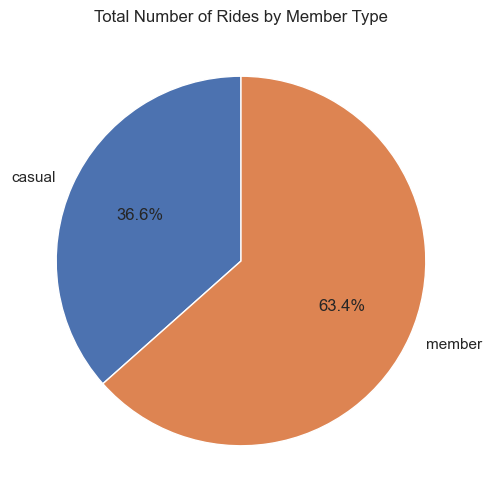

In [56]:
# Calculate the number of rides and average duration by member type
rides_stats = combined_df.groupby('member_casual').agg(
    total_rides=('trip_duration', 'size'),  # Count the number of rides
).reset_index()

# Pie Chart for Total Number of Rides by member_casual
plt.figure(figsize=(8, 6))
rides_stats['total_rides'].plot(kind='pie', labels=rides_stats['member_casual'], autopct='%1.1f%%', startangle=90)
plt.title('Total Number of Rides by Member Type')
plt.ylabel('')
plt.show()

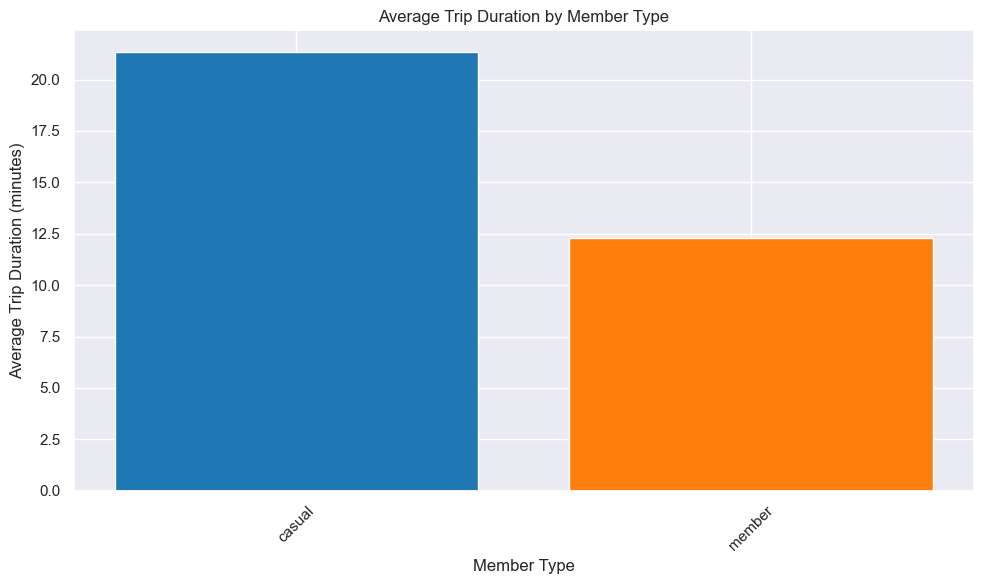

In [58]:
# Calculate the average trip duration by member type
avg_duration_by_member = combined_df.groupby('member_casual')['trip_duration'].mean().reset_index()

# Convert the average duration to minutes
avg_duration_by_member['avg_duration_minutes'] = avg_duration_by_member['trip_duration'].dt.total_seconds() / 60

# Define colors for member types
colors = {'casual': '#1f77b4', 'member': '#ff7f0e'}

# Plot the bar chart for average trip duration by member type
plt.figure(figsize=(10, 6))
plt.bar(avg_duration_by_member['member_casual'], 
        avg_duration_by_member['avg_duration_minutes'], 
        color=[colors[mtype] for mtype in avg_duration_by_member['member_casual']])
plt.xlabel('Member Type')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Average Trip Duration by Member Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2) Ride Distribution by Bike Type**

- The analysis of bike type preferences shows that both member and casual riders primarily use classic bikes (51%) and electric bikes (47%), while docked bikes account for only about 1% of total rides.

- This indicates that docked bikes are significantly less popular, possibly due to convenience factors or availability. The preference for classic and electric bikes suggests that riders value efficiency and ease of use, with electric bikes potentially being favored for longer or more effortless rides.

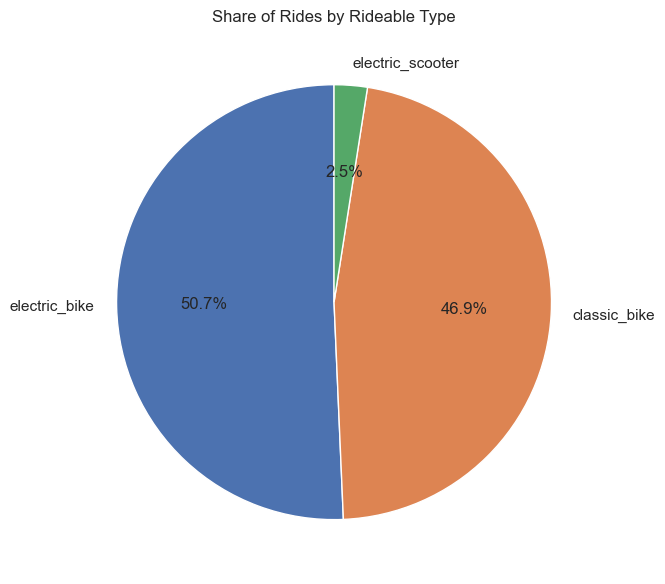

In [61]:
# Calculate the number of rides for each rideable type
rides_by_rideable_type = combined_df['rideable_type'].value_counts()

# Plot the pie chart for the share of rides by rideable type
plt.figure(figsize=(8, 6))
rides_by_rideable_type.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Share of Rides by Rideable Type')
plt.ylabel('')  # To remove the label for 'rideable_type'
plt.tight_layout()
plt.show()

**3) Monthly Ride Trends and Seasonal Impact**

- The 'trip_month' column was analyzed to determine the total number of rides taken each month.
- The highest number of rides occurred during July, August, and September, likely due to the summer season when weather conditions are favorable for cycling.
- A significant drop in rides was observed in December, possibly due to the onset of winter. The lowest number of rides was recorded in January and February, which aligns with peak snowfall months.
- As the weather improves with the arrival of spring, the number of rides begins to increase in March.
- This analysis highlights the strong influence of seasonal changes on bike usage, with higher ridership in warmer months and a decline during winter due to harsh weather conditions.

In [64]:
# Count total rides per month
monthly_rides = combined_df['trip_month'].value_counts()

# Sort months in calendar order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_rides = monthly_rides.reindex(month_order)

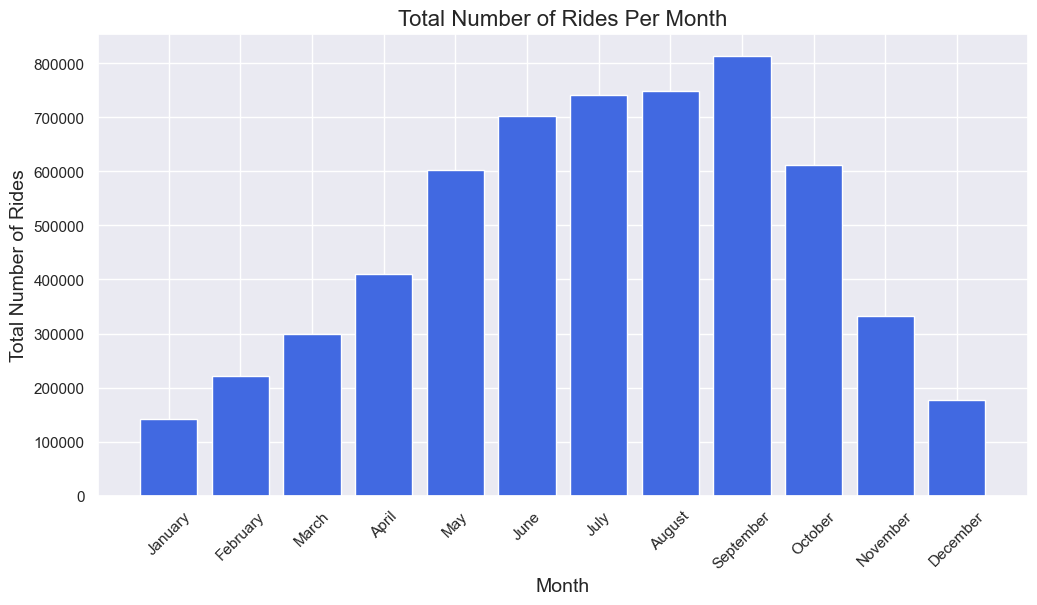

In [66]:
plt.figure(figsize=(12,6))
plt.bar(monthly_rides.index, monthly_rides.values, color='royalblue')

# Add labels and title
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Number of Rides", fontsize=14)
plt.title("Total Number of Rides Per Month", fontsize=16)
plt.xticks(rotation=45)  # Rotate month names for better visibility
plt.show()

**4) Weekly Ride Trends**

- The analysis of rides taken by the day of the week reveals distinct usage patterns between members and casual riders.
- The highest number of rides by members occurred on Tuesdays, Wednesdays, and Thursdays, indicating frequent weekday usage, likely for commuting purposes.
- In contrast, casual riders predominantly used bikes on weekends, suggesting recreational or leisure-based usage.
- This insight can help optimize bike availability by ensuring sufficient supply during peak usage times for both user groups.

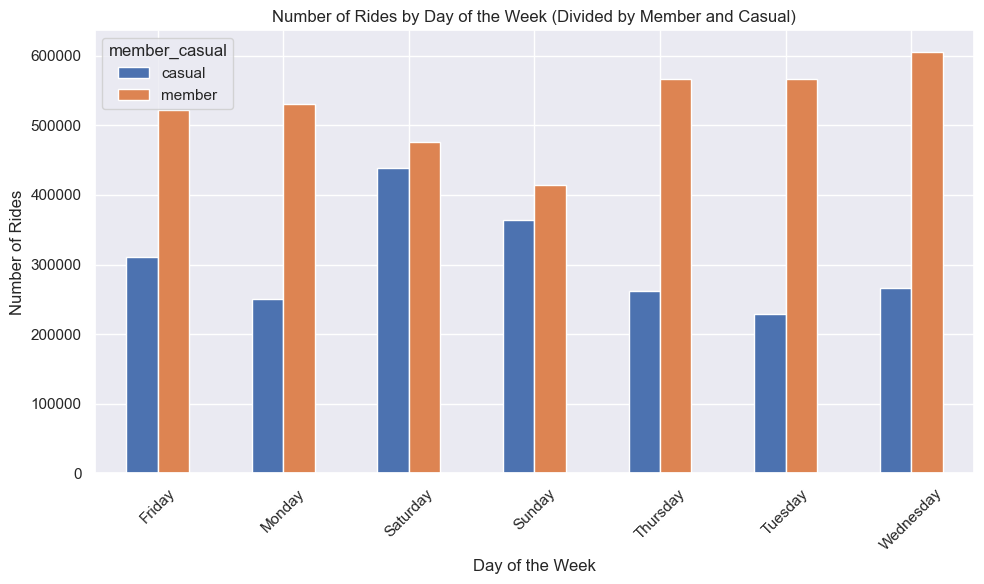

In [69]:
# Group by 'trip_day' and 'member_casual' and count the number of rides
rides_by_day_member_casual = combined_df.groupby(['trip_day', 'member_casual']).size().unstack(fill_value=0)

# Plot the column chart for the number of rides by day of the week
rides_by_day_member_casual.plot(kind='bar', figsize=(10, 6))

# Add labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day of the Week (Divided by Member and Casual)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

**5) Hourly Ride Trends**

- The distribution of rides by the hour of the day highlights different usage patterns between members and casual riders.
- Member riders primarily use bikes during peak office hours, with noticeable spikes at 8 AM and 5 PM, indicating they rely on bikes for commuting to and from work.
- In contrast, casual riders show increased usage throughout the day, with the highest activity occurring at 5 PM, likely due to leisure activities, sightseeing, or evening outings.
- Understanding these patterns can help with fleet distribution and bike availability, ensuring that enough bikes are available for commuters during rush hours and for casual riders during peak leisure times.

<Figure size 1000x600 with 0 Axes>

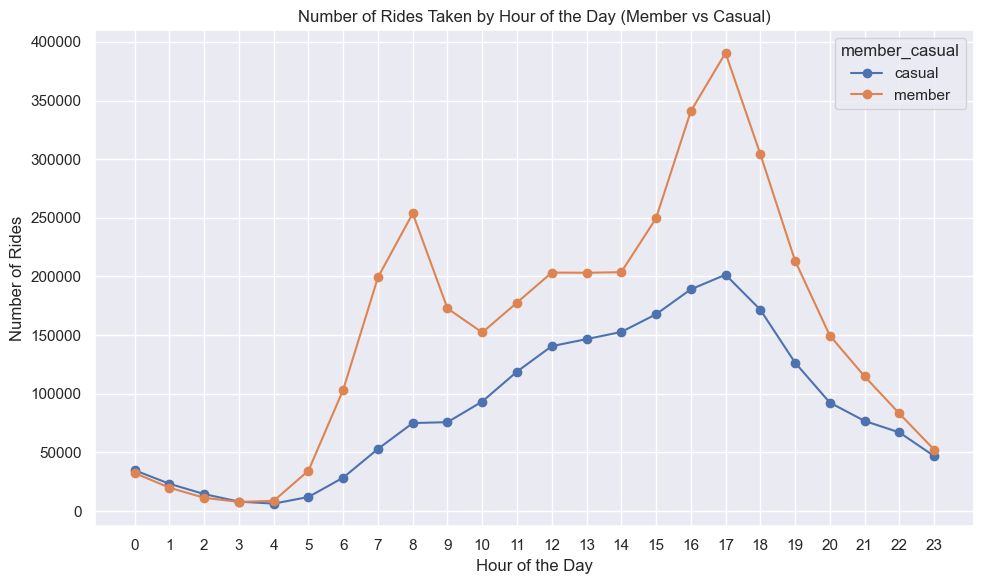

In [72]:
# Ensure 'started_at' column is in datetime format
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'], errors='coerce')

# Extract the hour of the day from 'started_at' column
combined_df['hour_of_day'] = combined_df['started_at'].dt.hour

# Group by 'hour_of_day' and 'member_casual' and count the number of rides
rides_by_hour_member_casual = combined_df.groupby(['hour_of_day', 'member_casual']).size().unstack(fill_value=0)

# Plot the line chart for number of rides by hour of the day
plt.figure(figsize=(10, 6))
rides_by_hour_member_casual.plot(kind='line', marker='o', figsize=(10, 6))

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.title('Number of Rides Taken by Hour of the Day (Member vs Casual)')
plt.xticks(range(0, 24))  # Set the x-axis to show all 24 hours
plt.grid(True)
plt.tight_layout()
plt.show()

## Geospatial Analysis

**Bike Station Usage Across Chicago: Member vs. Casual Riders**

- Casual users tend to use bikes in more central, scenic, or recreational areas—likely for short-term, one-off trips.
- Members depend on the service for regular commuting, suggesting consistent infrastructure demand across the city.
- Certain stations are shared hotspots, but optimizing them may require different strategies (e.g., more bikes for casuals on weekends, more docks for members on weekdays).
- Downtown is a high-demand area for both user types, but their usage patterns may differ by time of day or week.

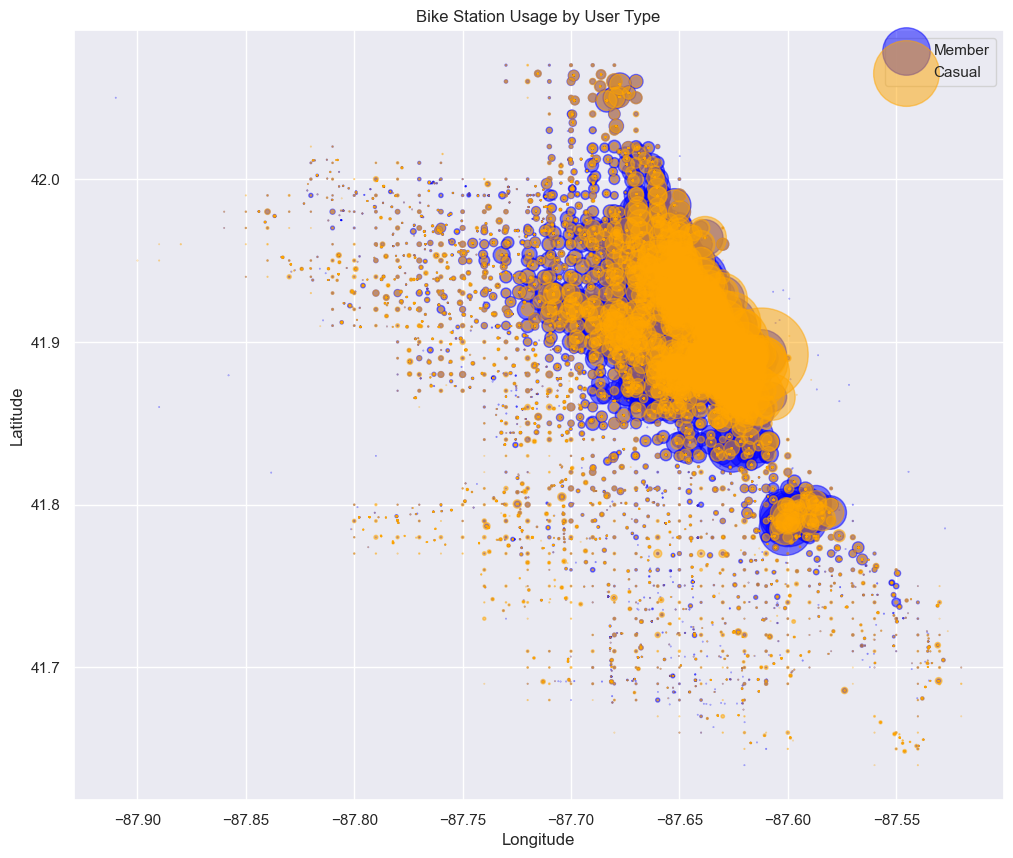

In [76]:
# Group by location and user type for counts
user_type_counts = combined_df.groupby(['start_lat', 'start_lng', 'member_casual']).size().reset_index(name='count')

# Separate members and casuals
members = user_type_counts[user_type_counts['member_casual'] == 'member']
casuals = user_type_counts[user_type_counts['member_casual'] == 'casual']

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(members['start_lng'], members['start_lat'], s=members['count']*0.1, c='blue', alpha=0.5, label='Member')
plt.scatter(casuals['start_lng'], casuals['start_lat'], s=casuals['count']*0.1, c='orange', alpha=0.5, label='Casual')

plt.title("Bike Station Usage by User Type")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

## Time Series Forecasting Analysis for Member vs. Casual Rider Bike Demand

**Strong Seasonality Pattern:**

- Both rider types follow a strong yearly seasonality, with summer being the peak period.

**Weekly Seasonality:**

- Members likely use bikes for commuting during the workweek.
- Casuals use bikes for recreation/leisure on weekends and possibly holidays.

**Off-season Decline:**

- Both rider types show clear upward trends into summer and decline in colder months.
- Members have more steady trends; casuals show sharper seasonal shifts.

In [85]:
!pip install prophet
from prophet import Prophet

12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing


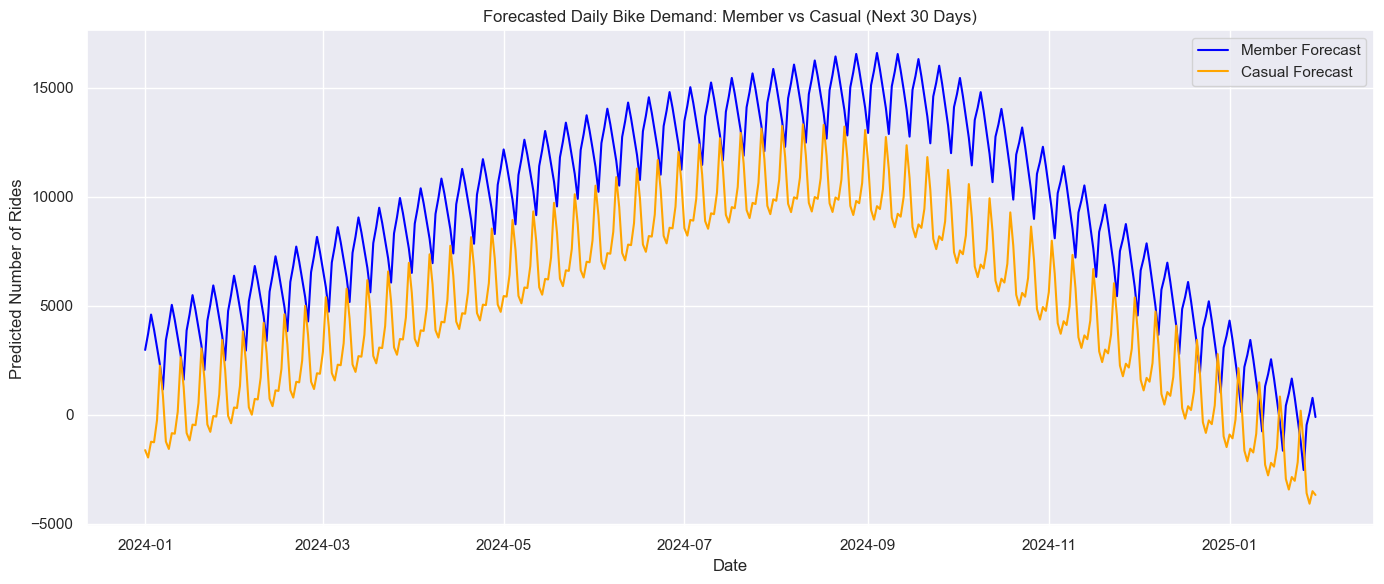


Member Rider Trend Components


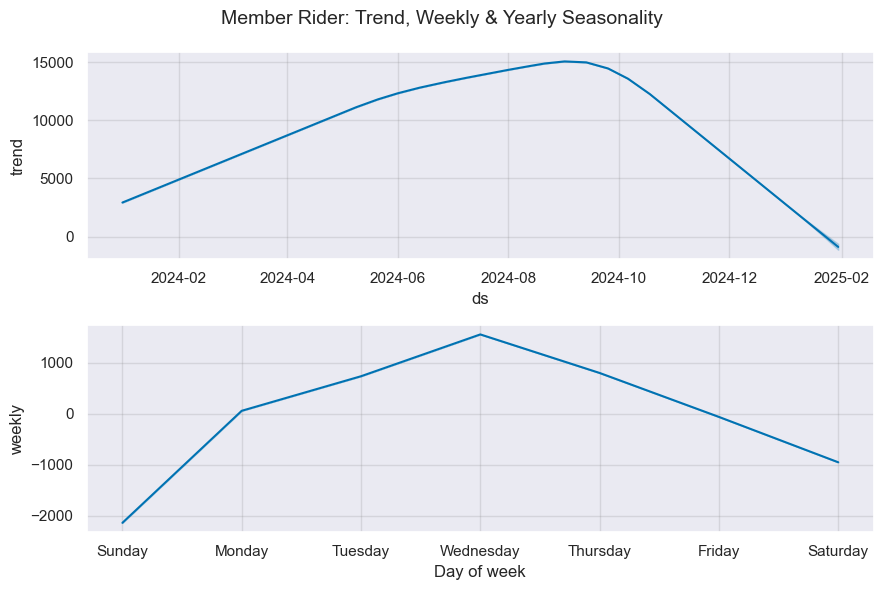


Casual Rider Trend Components


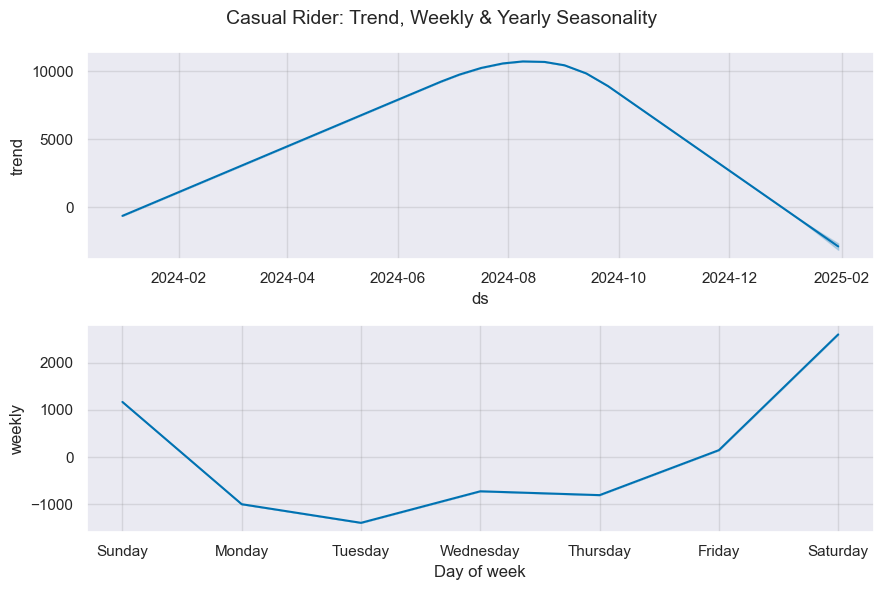

In [87]:
# Filter member and casual data
member_df = combined_df[combined_df['member_casual'] == 'member']
casual_df = combined_df[combined_df['member_casual'] == 'casual']

# Daily aggregation
def get_daily_df(data):
    daily = data.groupby(data['started_at'].dt.date).size().reset_index(name='ride_count')
    daily.columns = ['ds', 'y']
    daily['ds'] = pd.to_datetime(daily['ds'])
    return daily

member_daily = get_daily_df(member_df)
casual_daily = get_daily_df(casual_df)

# Fit Prophet models
member_model = Prophet()
casual_model = Prophet()

member_model.fit(member_daily)
casual_model.fit(casual_daily)

# Create future dataframes
future_period = 30
member_future = member_model.make_future_dataframe(periods=future_period)
casual_future = casual_model.make_future_dataframe(periods=future_period)

# Predict
member_forecast = member_model.predict(member_future)
casual_forecast = casual_model.predict(casual_future)

# Plot combined forecast
plt.figure(figsize=(14, 6))
plt.plot(member_forecast['ds'], member_forecast['yhat'], label='Member Forecast', color='blue')
plt.plot(casual_forecast['ds'], casual_forecast['yhat'], label='Casual Forecast', color='orange')
plt.title('Forecasted Daily Bike Demand: Member vs Casual (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Predicted Number of Rides')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly & Monthly Seasonality Components

print("\nMember Rider Trend Components")
member_model.plot_components(member_forecast)
plt.suptitle("Member Rider: Trend, Weekly & Yearly Seasonality", fontsize=14)
plt.tight_layout()
plt.show()

print("\nCasual Rider Trend Components")
casual_model.plot_components(casual_forecast)
plt.suptitle("Casual Rider: Trend, Weekly & Yearly Seasonality", fontsize=14)
plt.tight_layout()
plt.show()

## Strategic Recommendations from Data Visualization and Geospatial for Increasing Membership and Revenue

- Since casual riders tend to rent bikes for longer durations, the company could introduce incentives for members who use bikes for extended periods. This strategy may encourage casual riders to consider membership registration, offering them added value.

- Given that casual riders primarily rent bikes during the summer months, the company could explore introducing monthly or seasonal membership plans to attract these users and increase membership conversions.

- As casual riders mostly rent bikes on weekends and during the daytime, their usage pattern suggests leisure-oriented trips rather than commuting. This indicates a strong presence of tourists among casual riders. The company should focus its marketing efforts on tourists, highlighting the benefits of monthly or seasonal memberships to encourage them to sign up during their stay.

- For member riders, the company could improve availability in residential/commuter corridors and consider adding covered stations for year-round riders. The compnay should also use weekday rush-hour predictions for rebalancing. For Casual riders, the focus should be on availability near parks, downtown, lakefront and increasing bike counts during weekends & holidays, For casual, the company should target tourist-heavy times (midday, weekends)

## Strategic Recommendations from Time Series Forecasting Analysis for Increasing Bike Demand

- Launch conversion-focused campaigns in late spring (April–June) to target high casual traffic.
- Promote weekday-only passes for casual riders to test commute-style usage.
- Increase bike availability & station support during summer weekends for casuals and weekdays for members.
- Use this forecast to plan bike maintenance cycles, fleet rebalancing, and staffing levels.
- Use behavior-based segmentation: Promote benefits like cost savings & flexibility to casuals during their peak usage times.

## Challenges

**1) Handling Large Volume of Data**
- The dataset included 5 million+ rows, which made data loading, merging, and processing memory-intensive in Jupyter Notebook.
- Optimizing performance by setting data types, using efficient loops, and freeing memory with gc.collect() was essential.

**2) Combining Multiple Monthly Files**
- Data was split into 12 monthly files, requiring automated downloading, extraction from ZIPs, and concatenation.
- Ensuring that all columns aligned correctly and that no data was duplicated was a key challenge.

**3) Inconsistent Datetime Formats**
- The started_at and ended_at columns were read as object types and required manual conversion using pd.to_datetime() with errors='coerce'.
- Some records contained invalid or improperly formatted dates, requiring extra cleaning.

## Thank You